# Project Title
### Data Engineering Capstone Project

#### Project Summary

The objective of this project was to create an ETL pipeline for I94 immigration, global land temperatures and US demographics datasets to form an analytics database on immigration events. A use case for this analytics database is to find immigration patterns to the US. For example, we could try to find answears to questions such as, do people from countries with warmer or cold climate immigrate to the US in large numbers? 

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

## Import Libraries

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import configparser
import datetime as dt

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *

import plotly.plotly as py
import plotly.graph_objs as go
import requests
requests.packages.urllib3.disable_warnings()

import utility
import etl_functions

import importlib
importlib.reload(utility)
from utility import visualize_missing_values, clean_immigration, clean_temperature_data
from utility import clean_demographics_data, print_formatted_float

### Load Configuration Data

In [2]:
config = configparser.ConfigParser()
config.read('config.cfg')

os.environ['AWS_ACCESS_KEY_ID']=config['AWS']['AWS_ACCESS_KEY_ID']
os.environ['AWS_SECRET_ACCESS_KEY']=config['AWS']['AWS_SECRET_ACCESS_KEY']

### Create a Spark Session

In [3]:
spark = SparkSession.builder.\
    config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11").\
    enableHiveSupport().getOrCreate()

# Step 1: Scope the Project and Gather Data

## Project Scope 
<hr></hr>

To create the analytics database, the following steps will be carried out:
* Use Spark to load the data into dataframes.
* Exploratory data analysis of I94 immigration dataset to identify missing values and strategies for data cleaning.
* Exploratory data analysis of demographics dataset to identify missing values and strategies for data cleaning.
* Exploratory data analysis of global land temperatures by city dataset to identify missing values and strategies for data cleaning.
* Perform data cleaning functions on all the datasets.
* Create dimension tables.
    * Create immigration calendar dimension table from I94 immigration dataset, this table links to the fact table through the arrdate field.
    * Create country dimension table from the I94 immigration and the global temperatures dataset. The global land temperatures data was aggregated at country level. The table links to the fact table through the country of residence code allowing analysts to understand correlation between country of residence climate and immigration to US states. 
    * Create usa demographics dimension table from the us cities demographics data. This table links to the fact table through the state code field. 
    
* Create fact table from the clean I94 immigration dataset and the visa_type dimension.

<p>
The technology used in this project is <b>Amazon S3, Apache Sparkw</b>. Data will be read and staged from the customers repository using Spark.
</p>

While the whole project has been implemented on this notebook, provisions has been made to run the ETL on a spark cluster through etl.py. The etl.py script reads data from S3 and creates fact and dimesion tables through Spark that are loaded back into S3.

## Data Load and Descriptions
---

#### I94 Immigration Data: Data Description 
<hr style="background-color: #b7d0e2;"/> 

This data comes from the US National Tourism and Trade Office. In the past all foreign visitors to the U.S. arriving via air or sea were required to complete paper Customs and Border Protection Form I-94 Arrival/Departure Record or Form I-94W Nonimmigrant Visa Waiver Arrival/Departure Record and this dataset comes from this forms. 

This dataset forms the core of the data warehouse and the customer repository has a years worth of data for the year 2016 and the dataset is divided by month. For this project the data is in a folder located at ../../data/18-83510-I94-Data-2016/. Each months data is stored in an SAS binary database storage format <i>sas7bdat</i>. For this project we have chosen going to work with data for the month of April. However, the data extraction, transformation and loading utility functions have been designed to work with any month's worth of data.

##### Load I94 Immigration dataset

In [4]:
# read in the data
fname = '../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat'
immigration_df =spark.read.format('com.github.saurfang.sas.spark').load(fname)

In [5]:
# display the first five records
immigration_df.limit(5).toPandas()

cicid   i94yr  i94mon  i94cit  i94res i94port  arrdate  i94mode i94addr  \
0    6.0  2016.0     4.0   692.0   692.0     XXX  20573.0      NaN    None   
1    7.0  2016.0     4.0   254.0   276.0     ATL  20551.0      1.0      AL   
2   15.0  2016.0     4.0   101.0   101.0     WAS  20545.0      1.0      MI   
3   16.0  2016.0     4.0   101.0   101.0     NYC  20545.0      1.0      MA   
4   17.0  2016.0     4.0   101.0   101.0     NYC  20545.0      1.0      MA   

   depdate   ...     entdepu  matflag  biryear   dtaddto gender insnum  \
0      NaN   ...           U     None   1979.0  10282016   None   None   
1      NaN   ...           Y     None   1991.0       D/S      M   None   
2  20691.0   ...        None        M   1961.0  09302016      M   None   
3  20567.0   ...        None        M   1988.0  09302016   None   None   
4  20567.0   ...        None        M   2012.0  09302016   None   None   

  airline        admnum  fltno visatype  
0    None  1.897628e+09   None       B2  
1    None  3.736796e+09  00296       F1  
2      OS  6.666432e+08     93       B2  
3      AA  9.246846e+10  00199       B2  
4      AA  9.246846e+10  00199       B2  

[5 rows x 28 columns]

In [20]:
# count the total number of records
print_formatted_float(immigration_df.count())

3,096,313


In [8]:
immigration_df.select("visapost").dropDuplicates().show(5)

+--------+
|visapost|
+--------+
|     CRS|
|     KGL|
|     AKD|
|     BGM|
|     TRK|
+--------+
only showing top 5 rows



<b><i>Data dictionary</i></b>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">cicid</td><td class="tg-0pky">Unique record ID</td>
 <tr><td class="tg-0pky">i94yr</td><td class="tg-0pky">4 digit year</td>
 <tr><td class="tg-0pky">i94mon</td><td class="tg-0pky">Numeric month</td>
 <tr><td class="tg-0pky">i94cit</td><td class="tg-0pky">3 digit code for immigrant country of birth</td>
 <tr><td class="tg-0pky">i94res</td><td class="tg-0pky">3 digit code for immigrant country of residence </td>
 <tr><td class="tg-0pky">i94port</td><td class="tg-0pky">Port of admission</td>
 <tr><td class="tg-0pky">arrdate</td><td class="tg-0pky">Arrival Date in the USA</td>
 <tr><td class="tg-0pky">i94mode</td><td class="tg-0pky">Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td>
 <tr><td class="tg-0pky">i94addr</td><td class="tg-0pky">USA State of arrival</td>
 <tr><td class="tg-0pky">depdate</td><td class="tg-0pky">Departure Date from the USA</td>
 <tr><td class="tg-0pky">i94bir</td><td class="tg-0pky">Age of Respondent in Years</td>
 <tr><td class="tg-0pky">i94visa</td><td class="tg-0pky">Visa codes collapsed into three categories</td>
 <tr><td class="tg-0pky">count</td><td class="tg-0pky">Field used for summary statistics</td>
 <tr><td class="tg-0pky">dtadfile</td><td class="tg-0pky">Character Date Field - Date added to I-94 Files</td>
 <tr><td class="tg-0pky">visapost</td><td class="tg-0pky">Department of State where where Visa was issued </td>
 <tr><td class="tg-0pky">occup</td><td class="tg-0pky">Occupation that will be performed in U.S</td>
 <tr><td class="tg-0pky">entdepa</td><td class="tg-0pky">Arrival Flag - admitted or paroled into the U.S.</td>
 <tr><td class="tg-0pky">entdepd</td><td class="tg-0pky">Departure Flag - Departed, lost I-94 or is deceased</td>
 <tr><td class="tg-0pky">entdepu</td><td class="tg-0pky">Update Flag - Either apprehended, overstayed, adjusted to perm residence</td>
 <tr><td class="tg-0pky">matflag</td><td class="tg-0pky">Match flag - Match of arrival and departure records</td>
 <tr><td class="tg-0pky">biryear</td><td class="tg-0pky">4 digit year of birth</td>
 <tr><td class="tg-0pky">dtaddto</td><td class="tg-0pky">Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td>
 <tr><td class="tg-0pky">gender</td><td class="tg-0pky">Non-immigrant sex</td>
 <tr><td class="tg-0pky">insnum</td><td class="tg-0pky">INS number</td>
 <tr><td class="tg-0pky">airline</td><td class="tg-0pky">Airline used to arrive in U.S.</td>
 <tr><td class="tg-0pky">admnum</td><td class="tg-0pky">Admission Number</td>
 <tr><td class="tg-0pky">fltno</td><td class="tg-0pky">Flight number of Airline used to arrive in U.S.</td>
 <tr><td class="tg-0pky">visatype</td><td class="tg-0pky">Class of admission legally admitting the non-immigrant to temporarily stay in U.S.</td>
</table>

#### World Temperature Data: Data Description 
<hr style="background-color: #b7d0e2;"/> 

The World Temperature dataset comes from Kaggle and represents global land temperatures by city.

##### Load World Temperature data

In [39]:
file_name = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = spark.read.csv(file_name, header=True, inferSchema=True)

In [5]:
# display the first five records
temperature_df.show(n=5)

+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|                 dt|AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
|1743-11-01 00:00:00|             6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743-12-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-01-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-02-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744-03-01 00:00:00|              null|                         null|Århus|Denmark|  57.05N|   10.33E|
+-------------------+------------------+-----------------------------+-----+-------+--------+---------+
only showing top 5 rows



<b><i>Data dictionary</i></b>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">dt</td><td class="tg-0pky">Date</td>
 <tr><td class="tg-0pky">AverageTemperature</td><td class="tg-0pky">Global average land temperature in celsius</td>
 <tr><td class="tg-0pky">AverageTemperatureUncertainty</td><td class="tg-0pky">95% confidence interval around the average</td>
 <tr><td class="tg-0pky">City</td><td class="tg-0pky">Name of City</td>
 <tr><td class="tg-0pky">Country</td><td class="tg-0pky">Name of Country</td>
 <tr><td class="tg-0pky">Latitude</td><td class="tg-0pky">City Latitude</td>
 <tr><td class="tg-0pky">Longitude</td><td class="tg-0pky">City Longitude</td>
</table>

In [8]:
# check the total number of records
print_formatted_float(temperature_df.count())

8,599,212


#### U.S. City Demographic Data: Data Description 
<hr style="background-color: #b7d0e2;"/> 

This data comes from OpenSoft and contains information about the demographics of all US cities and census-designated places with a population greater or equal to 65,000. Original data comes from the US Census Bureau's 2015 American Community Survey.

##### Load the dataset

In [32]:
file_name = "us-cities-demographics.csv"
demographics_df = spark.read.csv(file_name, inferSchema=True, header=True, sep=';')

In [27]:
# display the first five records
demographics_df.limit(5).toPandas()

City          State  Median Age  Male Population  \
0     Silver Spring       Maryland        33.8            40601   
1            Quincy  Massachusetts        41.0            44129   
2            Hoover        Alabama        38.5            38040   
3  Rancho Cucamonga     California        34.5            88127   
4            Newark     New Jersey        34.6           138040   

   Female Population  Total Population  Number of Veterans  Foreign-born  \
0              41862             82463                1562         30908   
1              49500             93629                4147         32935   
2              46799             84839                4819          8229   
3              87105            175232                5821         33878   
4             143873            281913                5829         86253   

   Average Household Size State Code                       Race  Count  
0                    2.60         MD         Hispanic or Latino  25924  
1                    2.39         MA                      White  58723  
2                    2.58         AL                      Asian   4759  
3                    3.18         CA  Black or African-American  24437  
4                    2.73         NJ                      White  76402

<b><i>Data dictionary</i></b>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">City</td><td class="tg-0pky">City Name</td>
 <tr><td class="tg-0pky">State</td><td class="tg-0pky">US State where city is located</td>
 <tr><td class="tg-0pky">Median Age</td><td class="tg-0pky">Median age of the population</td>
 <tr><td class="tg-0pky">Male Population</td><td class="tg-0pky">Count of male population</td>
 <tr><td class="tg-0pky">Female Population</td><td class="tg-0pky">Count of female population</td>
 <tr><td class="tg-0pky">Total Population</td><td class="tg-0pky">Count of total population</td>
 <tr><td class="tg-0pky">Number of Veterans</td><td class="tg-0pky">Count of total Veterans</td>
 <tr><td class="tg-0pky">Foreign born</td><td class="tg-0pky">Count of residents of the city that were not born in the city</td>
 <tr><td class="tg-0pky">Average Household Size</td><td class="tg-0pky">Average city household size</td>
 <tr><td class="tg-0pky">State Code</td><td class="tg-0pky">Code of the US state</td>
 <tr><td class="tg-0pky">Race</td><td class="tg-0pky">Respondent race</td>
 <tr><td class="tg-0pky">Count</td><td class="tg-0pky">Count of city's individual per race</td>
</table>

In [28]:
# check the total number of records
print_formatted_float(demographics_df.count())

2,891


# Step 2: Explore and Assess the Data

## Exploratory Data Analysis: Immigration data
---

In [13]:
# list all files in the customer repository
files = os.listdir('../../data/18-83510-I94-Data-2016/')
files

['i94_apr16_sub.sas7bdat',
 'i94_sep16_sub.sas7bdat',
 'i94_nov16_sub.sas7bdat',
 'i94_mar16_sub.sas7bdat',
 'i94_jun16_sub.sas7bdat',
 'i94_aug16_sub.sas7bdat',
 'i94_may16_sub.sas7bdat',
 'i94_jan16_sub.sas7bdat',
 'i94_oct16_sub.sas7bdat',
 'i94_jul16_sub.sas7bdat',
 'i94_feb16_sub.sas7bdat',
 'i94_dec16_sub.sas7bdat']

In [14]:
# lets see the dataframe schema
immigration_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

#### Visualize Missing Values
---

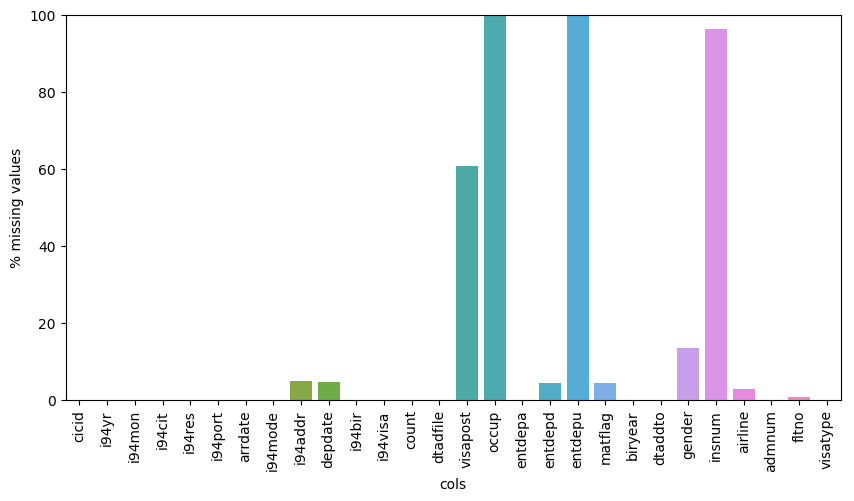

In [53]:
# now visualize missing values
utility.visualize_missing_values_spark(immigration_df)

#### Data Cleaning steps:
---
> Drop all columns with over 90% missing values. Columns with over 90% missing values are not deemed to contain sufficient data to be used for analytics.

> Drop all rows with 100% missing values. 

###### Drop columns with significant missing values

In [18]:
# columns with over 90% missing values
cols = ['occup', 'entdepu','insnum']

# drop these columns
new_immig_df = immigration_df.drop(*cols)

In [21]:
# display the new schema
new_immig_df.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = true)
 |-- fltno: string (nullable = true)
 |-- visatype: string (nullable = true)



In [22]:
# drop duplicate entries
new_immig_df = new_immig_df.dropDuplicates(['cicid'])

In [23]:
# get a count after dropping duplicates
print_formatted_float(new_immig_df.count())

3,096,313


> it looks like our data has no duplicates

In [27]:
# drop rows with missing values
new_immig_df = new_immig_df.dropna(how='all', subset=['cicid'])

In [28]:
# get a count after dropping rows with missing values
print_formatted_float(new_immig_df.count())

3,096,313


> Immigration data has no rows with missing record ID

In [5]:
# clean the immigration dataframe
new_immigration_df = utility.clean_spark_immigration_data(immigration_df)

Total records in dataframe: 3,096,313
Total records after cleaning: 3,096,313


## Exploratory Data Analysis: World Temperature Data
---

In [9]:
# print dataframe schema
temperature_df.printSchema()

root
 |-- dt: timestamp (nullable = true)
 |-- AverageTemperature: double (nullable = true)
 |-- AverageTemperatureUncertainty: double (nullable = true)
 |-- City: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)



#### Visualize Missing Values
---

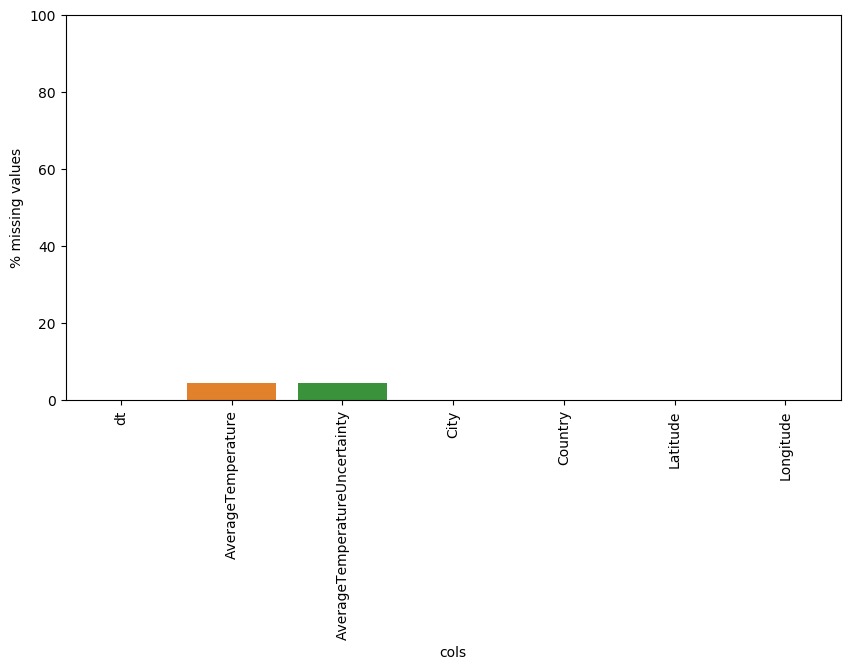

In [20]:
# visualize missing values by columns 
temperature_df2 = temperature_df.withColumn("dt",col("dt").cast(StringType())) # convert dt column type to string
utility.visualize_missing_values_spark(temperature_df2)

#### Data Cleaning Steps

-  Drop all rows with missing average temperature
-  Drop duplicate columns 

In [40]:
# clean the data
new_temperature_df = utility.clean_spark_temperature_data(temperature_df)

Total records in dataframe: 8,599,212
Total records after dropping rows with missing values: 364,130
Rows dropped after accounting for duplicates: 44,299


## Exploratory Data Analysis: U.S. City Demographic Data 
---

In [29]:
# count the number of records in dataset
print_formatted_float(demographics_df.count())

2,891


In [30]:
# print database schema
demographics_df.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: integer (nullable = true)
 |-- Female Population: integer (nullable = true)
 |-- Total Population: integer (nullable = true)
 |-- Number of Veterans: integer (nullable = true)
 |-- Foreign-born: integer (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: integer (nullable = true)



#### Visualize Missing Values
---

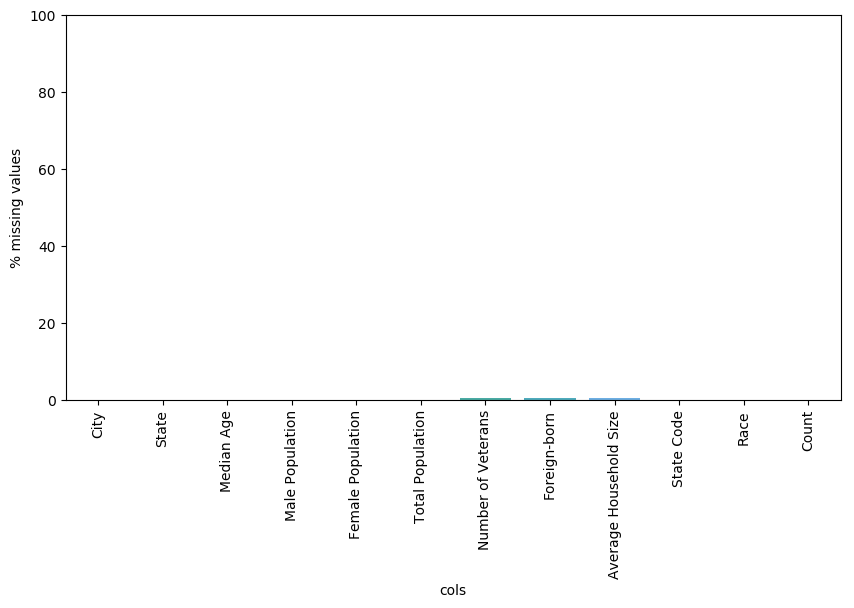

In [31]:
utility.visualize_missing_values_spark(demographics_df)

In [33]:
# View columns with missing data
nulls_df = pd.DataFrame(data= demographics_df.toPandas().isnull().sum(), columns=['values'])
nulls_df = nulls_df.reset_index()
nulls_df.columns = ['cols', 'values']

# calculate % missing values
nulls_df['% missing values'] = 100*nulls_df['values']/demographics_df.count()
nulls_df[nulls_df['% missing values']>0]

cols  values  % missing values
3         Male Population       3          0.103770
4       Female Population       3          0.103770
6      Number of Veterans      13          0.449671
7            Foreign-born      13          0.449671
8  Average Household Size      16          0.553442

#### Data Cleaning Steps

-  This dataset has very few missing values and it is thus safe to drop records with missing values
-  Drop duplicate columns 

In [33]:
# clean demographics data
new_demographics_df = utility.clean_spark_demographics_data(demographics_df)

Rows dropped with missing values: 16
Rows dropped after accounting for duplicates: 0


# Step 3: Define the Data Model
#### 3.1 Conceptual Data Model

![Database schema](conceptual_model.png)

The country dimension table is made up of data from the global land temperatures by city and the immigration datasets. The combination of these two datasets allows analysts to study correlations between global land temperatures and immigration patterns to the US.

The us demographics dimension table comes from the demographics dataset and links to the immigration fact table at US state level. This dimension would allow analysts to get insights into migration patterns into the US based on demographics as well as overall population of states. We could ask questions such as, do populous states attract more visitors on a monthly basis? One envisions a dashboard that could be designed based on the data model with drill downs into gradular information on visits to the US. Such a dashboard could foster a culture of data driven decision making within tourism and immigration departments at state level. 

The visa type dimension table comes from the immigration datasets and links to the immigaration via the visa_type_key. 

The immigration fact table is the heart of the data model. This table's data comes from the immigration data sets and contains keys that links to the dimension tables. The data dictionary of the immigration dataset contains detailed information on the data that makes up the fact table. 


#### 3.2 Mapping Out Data Pipelines
The pipeline steps are as follows:

* Load the datasets
* Clean the I94 Immigration data to create Spark dataframe for each month
* Create visa_type dimension table
* Create calendar dimension table
* Extract clean global temperatures data
* Create country dimension table
* Create immigration fact table
* Load demographics data
* Clean demographics data
* Create demographic dimension table

# Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

##### Create the immigration calendar dimension table
---

In [34]:
def create_immigration_calendar_dimension(df, output_data):
    """This function creates an immigration calendar based on arrival date
    
    :param df: spark dataframe of immigration events
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # create a udf to convert arrival date in SAS format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # create initial calendar df from arrdate column
    calendar_df = df.select(['arrdate']).withColumn("arrdate", get_datetime(df.arrdate)).distinct()
    
    # expand df by adding other calendar columns
    calendar_df = calendar_df.withColumn('arrival_day', dayofmonth('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_week', weekofyear('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_month', month('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_year', year('arrdate'))
    calendar_df = calendar_df.withColumn('arrival_weekday', dayofweek('arrdate'))

    # create an id field in calendar df
    calendar_df = calendar_df.withColumn('id', monotonically_increasing_id())
    
    # write the calendar dimension to parquet file
    partition_columns = ['arrival_year', 'arrival_month', 'arrival_week']
    calendar_df.write.parquet(output_data + "immigration_calendar", partitionBy=partition_columns, mode="overwrite")
    
    return calendar_df

In [35]:
output_data = "tables/"

In [36]:
calendar_df = create_immigration_calendar_dimension(new_immigration_df, output_data)

##### Create the country dimension table
---

In [8]:
def create_country_dimension_table(df, temp_df, output_data):
    """This function creates a country dimension from the immigration and global land temperatures data.
    
    :param df: spark dataframe of immigration events
    :temp_df: spark dataframe of global land temperatures data.
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # get the aggregated temperature data
    agg_temp = utility.aggregate_temperature_data(temp_df).toPandas()
    # load the i94res to country mapping data
    mapping_codes = pd.read_csv('i94res.csv')
    
    @udf('string')
    def get_country_average_temperature(name):
        print("Processing: ", name)
        avg_temp = agg_temp[agg_temp['Country']==name]['average_temperature']
        
        if not avg_temp.empty:
            return str(avg_temp.iloc[0])
        
        return None
    
    @udf()
    def get_country_name(code):
        name = mapping_codes[mapping_codes['code']==code]['Name'].iloc[0]
        
        if name:
            return name.title()
        return None
        
    # select and rename i94res column
    dim_df = df.select(['i94res']).distinct() \
                .withColumnRenamed('i94res', 'country_code')
    
    # create country_name column
    dim_df = dim_df.withColumn('country_name', get_country_name(dim_df.country_code))
    
    # create average_temperature column
    dim_df = dim_df.withColumn('average_temperature', get_country_average_temperature(dim_df.country_name))
    
    # write the dimension to a parquet file
    dim_df.write.parquet(output_data + "country", mode="overwrite")
    
    return dim_df

In [45]:
country_dim_f = create_country_dimension_table(new_immigration_df, new_temperature_df, output_data)

In [46]:
country_dim_f.show(5)

+------------+------------+-------------------+
|country_code|country_name|average_temperature|
+------------+------------+-------------------+
|       692.0|     Ecuador|      20.5391705374|
|       299.0|    Mongolia|     -3.36548531952|
|       576.0| El Salvador|      25.2628525509|
|       735.0|  Montenegro|      10.2210401137|
|       206.0|   Hong Kong|      21.4236961538|
+------------+------------+-------------------+
only showing top 5 rows



##### Create the visa type dimension table
---

In [13]:
def create_visa_type_dimension_table(df, output_data):
    """This function creates a visa type dimension from the immigration data.
    
    :param df: spark dataframe of immigration events
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # create visatype df from visatype column
    visatype_df = df.select(['visatype']).distinct()
    
    # add an id column
    visatype_df = visatype_df.withColumn('visa_type_key', monotonically_increasing_id())
    
    # write dimension to parquet file
    visatype_df.write.parquet(output_data + "visatype", mode="overwrite")
    
    return visatype_df

def get_visa_type_dimension(output_data):
    return spark.read.parquet(output_data + "visatype")

In [10]:
# test create visa_type dimension function
visatype_df = create_visa_type_dimension_table(new_immigration_df, output_data)
visatype_df.show(n=5)

+--------+-------------+
|visatype|visa_type_key|
+--------+-------------+
|      F2| 103079215104|
|     GMB| 352187318272|
|      B2| 369367187456|
|      F1| 498216206336|
|     CPL| 601295421440|
+--------+-------------+
only showing top 5 rows



##### Create the demographics dimension table
---

In [43]:
def create_demographics_dimension_table(df, output_data):
    """This function creates a us demographics dimension table from the us cities demographics data.
    
    :param df: spark dataframe of us demographics survey data
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing demographics dimension
    """
    dim_df = df.withColumnRenamed('Median Age','median_age') \
            .withColumnRenamed('Male Population', 'male_population') \
            .withColumnRenamed('Female Population', 'female_population') \
            .withColumnRenamed('Total Population', 'total_population') \
            .withColumnRenamed('Number of Veterans', 'number_of_veterans') \
            .withColumnRenamed('Foreign-born', 'foreign_born') \
            .withColumnRenamed('Average Household Size', 'average_household_size') \
            .withColumnRenamed('State Code', 'state_code')
    # lets add an id column
    dim_df = dim_df.withColumn('id', monotonically_increasing_id())
    
    # write dimension to parquet file
    dim_df.write.parquet(output_data + "demographics", mode="overwrite")
    
    return dim_df

In [44]:
demographics_dim_df = create_demographics_dimension_table(new_demographics_df, output_data)
demographics_dim_df.limit(5).toPandas()

City           State  median_age  male_population  female_population  \
0      Quincy   Massachusetts        41.0            44129              49500   
1  Wilmington  North Carolina        35.5            52346              63601   
2       Tampa         Florida        35.3           175517             193511   
3    Gastonia  North Carolina        36.9            35527              39023   
4       Tyler           Texas        33.9            50422              53283   

   total_population  number_of_veterans  foreign_born  average_household_size  \
0             93629                4147         32935                    2.39   
1            115947                5908          7401                    2.24   
2            369028               20636         58795                    2.47   
3             74550                3537          5715                    2.67   
4            103705                4813          8225                    2.59   

  state_code                               Race  Count  id  
0         MA                              White  58723   0  
1         NC                              Asian   3152   1  
2         FL                 Hispanic or Latino  95154   2  
3         NC                              Asian   2788   3  
4         TX  American Indian and Alaska Native   1057   4

##### Create the immigration fact table
---

In [51]:
def create_immigration_fact_table(df, output_data):
    """This function creates an country dimension from the immigration and global land temperatures data.
    
    :param df: spark dataframe of immigration events
    :param visa_type_df: spark dataframe of global land temperatures data.
    :param output_data: path to write dimension dataframe to
    :return: spark dataframe representing calendar dimension
    """
    # get visa_type dimension
    dim_df = get_visa_type_dimension(output_data).toPandas()
    
    @udf('string')
    def get_visa_key(visa_type):
        """user defined function to get visa key
        
        :param visa_type: US non-immigrant visa type
        :return: corresponding visa key
        """
        key_series = dim_df[dim_df['visatype']==visa_type]['visa_type_key']
        
        if not key_series.empty:
            return str(key_series.iloc[0])
        
        return None
    
    # create a udf to convert arrival date in SAS format to datetime object
    get_datetime = udf(lambda x: (dt.datetime(1960, 1, 1).date() + dt.timedelta(x)).isoformat() if x else None)
    
    # rename columns to align with data model
    df = df.withColumnRenamed('cicid','record_id') \
            .withColumnRenamed('i94res', 'country_residence_code') \
            .withColumnRenamed('i94addr', 'state_code') 
    
    # create visa_type key
    df = df.withColumn('visa_type_key', get_visa_key('visatype'))
    
    # convert arrival date into datetime object
    df = df.withColumn("arrdate", get_datetime(df.arrdate))
    
    # write dimension to parquet file
    df.write.parquet(output_data + "immigration_fact", mode="overwrite")
    
    return df

In [52]:
immigration_fact_df = create_immigration_fact_table(new_immigration_df, output_data)

In [ ]:
def run_pipeline():
    # load data
    
    # run cleaning functions
    
    # create fact and dimension tables
    
    

#### 4.2 Data Quality Checks
The data quality checks ensures that the ETL has created fact and dimension tables with adequate records. 

In [47]:
table_dfs = {
    'immigration_fact': immigration_fact_df,
    'visa_type_dim': visatype_df,
    'calendar_dim': calendar_df,
    'usa_demographics_dim': demographics_dim_df,
    'country_dim': country_dim_f
}
for table_name, table_df in table_dfs.items():
    # quality check for table
    etl_functions.quality_checks(table_df, table_name)

Data quality check passed for immigration_fact with 3,096,313 records.
Data quality check passed for visa_type_dim with 17 records.
Data quality check passed for calendar_dim with 30 records.
Data quality check passed for usa_demographics_dim with 2,875 records.
Data quality check passed for country_dim with 229 records.


#### 4.3 Data dictionary 

##### Fact Table - data dictionary

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">record_id</td><td class="tg-0pky">Unique record ID</td></tr>
 <tr><td class="tg-0pky">country_residence_code</td><td class="tg-0pky">3 digit code for immigrant country of residence </td></tr>    
 <tr><td class="tg-0pky">visa_type_key</td><td class="tg-0pky">A numerical key that links to the visa_type dimension table</td></tr>
 <tr><td class="tg-0pky">state_code</td><td class="tg-0pky">US state of arrival</td></tr>
 <tr><td class="tg-0pky">i94yr</td><td class="tg-0pky">4 digit year</td></tr>
 <tr><td class="tg-0pky">i94mon</td><td class="tg-0pky">Numeric month</td></tr>
 <tr><td class="tg-0pky">i94port</td><td class="tg-0pky">Port of admission</td></tr>
 <tr><td class="tg-0pky">arrdate</td><td class="tg-0pky">Arrival Date in the USA</td></tr>
 <tr><td class="tg-0pky">i94mode</td><td class="tg-0pky">Mode of transportation (1 = Air; 2 = Sea; 3 = Land; 9 = Not reported)</td></tr>
 <tr><td class="tg-0pky">i94addr</td><td class="tg-0pky">USA State of arrival</td></tr>
 <tr><td class="tg-0pky">depdate</td><td class="tg-0pky">Departure Date from the USA</td></tr>
 <tr><td class="tg-0pky">i94bir</td><td class="tg-0pky">Age of Respondent in Years</td></tr>
 <tr><td class="tg-0pky">i94visa</td><td class="tg-0pky">Visa codes collapsed into three categories</td></tr>
 <tr><td class="tg-0pky">count</td><td class="tg-0pky">Field used for summary statistics</td></tr>
 <tr><td class="tg-0pky">dtadfile</td><td class="tg-0pky">Character Date Field - Date added to I-94 Files</td></tr>
 <tr><td class="tg-0pky">visapost</td><td class="tg-0pky">Department of State where where Visa was issued </td></tr>
 <tr><td class="tg-0pky">occup</td><td class="tg-0pky">Occupation that will be performed in U.S</td></tr>
 <tr><td class="tg-0pky">entdepa</td><td class="tg-0pky">Arrival Flag - admitted or paroled into the U.S.</td></tr>
 <tr><td class="tg-0pky">entdepd</td><td class="tg-0pky">Departure Flag - Departed, lost I-94 or is deceased</td></tr>
 <tr><td class="tg-0pky">entdepu</td><td class="tg-0pky">Update Flag - Either apprehended, overstayed, adjusted to perm residence</td></tr>
 <tr><td class="tg-0pky">matflag</td><td class="tg-0pky">Match flag - Match of arrival and departure records</td></tr>
 <tr><td class="tg-0pky">biryear</td><td class="tg-0pky">4 digit year of birth</td></tr>
 <tr><td class="tg-0pky">dtaddto</td><td class="tg-0pky">Character Date Field - Date to which admitted to U.S. (allowed to stay until)</td></tr>
 <tr><td class="tg-0pky">gender</td><td class="tg-0pky">Non-immigrant sex</td></tr>
</table>

##### Country Dimension Table - data dictionary
<p>  
<i>The country code and country_name fields come from the labels description SAS file while the average_temperature data comes from the global land temperature by cities data.</i>
</p>
<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">country_code</td><td class="tg-0pky">Unique country code</td></tr>
 <tr><td class="tg-0pky">country_name</td><td class="tg-0pky">Name of country</td></tr>    
 <tr><td class="tg-0pky">average_temperature</td><td class="tg-0pky">Average temperature of country</td></tr>
</table>

##### Visa Type Dimension Table - data dictionary
<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">visa_type_key</td><td class="tg-0pky">Unique id for each visa issued</td></tr>
 <tr><td class="tg-0pky">visa_type</td><td class="tg-0pky">Name of visa</td></tr>
</table>

 ##### Immigration Calendar Dimension Table - data dictionary
<p>
<i>The whole of this dataset comes from the immigration dataset.</i>
</p>
<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">id</td><td class="tg-0pky">Unique id</td></tr>
 <tr><td class="tg-0pky">arrdate</td><td class="tg-0pky">Arrival date into US</td></tr>    
 <tr><td class="tg-0pky">arrival_year</td><td class="tg-0pky">Arrival year into US</td></tr>
 <tr><td class="tg-0pky">arrival_month</td><td class="tg-0pky">Arrival MonthS</td></tr>
 <tr><td class="tg-0pky">arrival_day</td><td class="tg-0pky">Arrival Day</td></tr>
 <tr><td class="tg-0pky">arrival_week</td><td class="tg-0pky">Arrival Week</td></tr>
 <tr><td class="tg-0pky">arrival_weekday</td><td class="tg-0pky">Arrival WeekDay</td></tr>
</table>

##### US Demographics Dimension Table - data dictionary
<p>
<i>The whole of this dataset comes from the us cities demographics data.</i>
</p>

<table class="tg" align="left">
  <tr>
    <th class="tg-0pky">Feature</th>
    <th class="tg-0pky">Description</th>
  </tr>
 <tr><td class="tg-0pky">id</td><td class="tg-0pky">Record id</td>
 <tr><td class="tg-0pky">state_code</td><td class="tg-0pky">US state code </td>
 <tr><td class="tg-0pky">City</td><td class="tg-0pky">City Name</td>
 <tr><td class="tg-0pky">State</td><td class="tg-0pky">US State where city is located</td>
 <tr><td class="tg-0pky">Median Age</td><td class="tg-0pky">Median age of the population</td>
 <tr><td class="tg-0pky">Male Population</td><td class="tg-0pky">Count of male population</td>
 <tr><td class="tg-0pky">Female Population</td><td class="tg-0pky">Count of female population</td>
 <tr><td class="tg-0pky">Total Population</td><td class="tg-0pky">Count of total population</td>
 <tr><td class="tg-0pky">Number of Veterans</td><td class="tg-0pky">Count of total Veterans</td>
 <tr><td class="tg-0pky">Foreign born</td><td class="tg-0pky">Count of residents of the city that were not born in the city</td>
 <tr><td class="tg-0pky">Average Household Size</td><td class="tg-0pky">Average city household size</td>
 <tr><td class="tg-0pky">Race</td><td class="tg-0pky">Respondent race</td>
 <tr><td class="tg-0pky">Count</td><td class="tg-0pky">Count of city's individual per race</td>
</table>

#### Step 5: Complete Project Write Up
* Rationale for the choice of tools and technologies for the project
    * Apache spark was used because of:
        * it's ability to handle multiple file formats with large amounts of data. 
        * Apache Spark offers a lightning-fast unified analytics engine for big data.
        * Spark has easy-to-use APIs for operating on large datasets
* Propose how often the data should be updated and why.
    * The current I94 immigration data is updated monthly, and hence the data will be updated monthly. 
* Write a description of how you would approach the problem differently under the following scenarios:
 * The data was increased by 100x.
     * Spark can handle the increase but we would consider increasing the number of nodes in our cluster.
 * The data populates a dashboard that must be updated on a daily basis by 7am every day.
     * In this scenario, Apache Airflow will be used to schedule and run data pipelines.
 * The database needed to be accessed by 100+ people.
     * In this scenario, we would move our analytics database into Amazon Redshift. 